In [1]:
!pip3 freeze > requirements.txt

In [2]:
%history -g -f history

In [3]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_context('paper')
plt.style.use('seaborn-paper')

def plot_bar(data, x_label, title, hue=None, save=False, prefix=''):
    plt.title(title)
    plt.tight_layout()
    sc = sns.countplot(data=data, x=x_label, palette='colorblind', hue=hue)
    sc.set(ylabel='Count')
    if save:
        plt.savefig('graphs/{}_bar_chart_{}.pdf'.format(prefix, title), dpi=300, bbox_inches='tight')
    return plt


def plot_line2(data, x, y, x_label, y_label, title, hue=None, ci=95, style=None, save=False, prefix=''):
    plt.title(title)
    plt.tight_layout()
    sc = sns.lineplot(x=x, y=y, data=data, palette='colorblind', hue=hue, style=style, ci=ci)
    sc.set(xlabel=x_label, ylabel=y_label)
    if save:
        plt.savefig('graphs/{}_plot_chart_{}.pdf'.format(prefix, title), dpi=300, bbox_inches='tight')
    return plt


def plot_line(data, x, y, x_label, y_label, title, x2=None, y2=None, y2_label=None, save=False, prefix=''):
    plt.title(title)
    plt.tight_layout()
    sc = sns.lineplot(x=x, y=y, data=data, palette='colorblind', ci=None)
    sc.set(xlabel=x_label, ylabel=y_label)
    if x2 is not None:
        anx = plt.twinx()
        sc = sns.lineplot(x=x2, y=y2, data=data, palette='colorblind', color='r', ax=anx, ci=None)
        sc.set(ylabel=y2_label)
        anx.figure.tight_layout()
    if save:
        plt.savefig('graphs/{}_plot_chart_{}.pdf'.format(prefix, title), dpi=300, bbox_inches='tight')
    return plt


def plot_hist(data, x, title, hue, save=False, prefix=''):
    plt.title(title)
    plt.tight_layout()
    sc = sns.histplot(data=data, x=x, hue=hue, palette='colorblind', discrete=True, multiple='stack')
    plt.xticks(range(1,10))
    if save:
        plt.savefig('graphs/{}_hist_{}.pdf'.format(prefix, title), dpi=300, bbox_inches='tight')
    return plt
    

In [5]:
try:
    cred = credentials.Certificate('./serviceAccount.json')
    firebase_admin.initialize_app(cred)
    db = firestore.client()
except Exception as e:
    print(e)

In [6]:
def set_updated_key(item_key, obj, doc):
    for key, value in obj.items():
        updated_key = "{}_{}".format(item_key, key)
        doc[updated_key] = value


def squash_doc(doc):
    keys = ['validationMetrics', 'oobMetrics', 'trainingInfo']
    for key in keys:
        obj = doc.get(key, None)
        if obj is not None:
            set_updated_key(key, obj, doc)
            del doc[key]
    return doc

In [7]:
all_models_csv = Path('./data/all_docs.csv')
all_models_docs = list()
all_models_pd = None

if all_models_csv.is_file():
    print('csv exists, using that')
    all_models_pd = pd.read_csv(all_models_csv, parse_dates=[2])
else:
    print('csv does not exist, getting data from firestore')
    doc_stream = db.collection(u'modelStats').stream()
    for doc in doc_stream:
        all_models_docs.append(squash_doc(doc.to_dict()))
    all_models_pd = pd.DataFrame(all_models_docs)
    all_models_pd.to_csv(all_models_csv, index=False)

csv exists, using that


In [8]:
connections_csv = Path('./data/all_connections.csv')
connections_docs = list()
connections_pd = None

if connections_csv.is_file():
    print('csv exists, using that')
    connections_pd = pd.read_csv(connections_csv)
else:
    print('csv does not exist, getting data from firestore')
    doc_stream = db.collection(u'connections').stream()
    for doc in doc_stream:
        connections_docs.append(doc.to_dict())
    connections_pd = pd.DataFrame(connections_docs)
    connections_pd.to_csv(connections_csv, index=False)

csv exists, using that


In [9]:
def to_dt(ts):
    return pd.to_datetime(ts, utc=True)

def to_dt2(ts):
    return pd.to_datetime(ts, utc=True, unit='ms')

def confusion_na(cm):
    if cm.startswith('['):
        return ''
    return cm

config_1_date = pd.to_datetime(np.datetime64('2021-03-03'), utc=True)
config_1_date_end = pd.to_datetime(np.datetime64(1615547734696, 'ms'), utc=True)

config_2_date = pd.to_datetime(np.datetime64('2021-03-12'), utc=True)
config_2_date_end = pd.to_datetime(np.datetime64(1616253120904, 'ms'), utc=True)

config_3_date = pd.to_datetime(np.datetime64('2021-03-21'), utc=True)
config_3_date_end = pd.to_datetime(np.datetime64(1617058800000, 'ms'), utc=True)

def set_trial(ts, config_1_date, config_1_date_end, start2, end2, start3, end3):
    if config_1_date <= ts <= config_1_date_end:
        return 1
    elif config_2_date <= ts <= config_2_date_end:
        return 2
    elif config_3_date <= ts <= config_3_date_end:
        return 3
    return 0

def set_day_of_trial(row, config_1_date, config_2_date, config_3_date):
    ts = None
    if 'timestamp_utc' in row.index:
        ts = row.timestamp_utc
    else:
        ts = row.event_timestamp
    trial = row.trial
    if ts is None: return -1
    day = -1
    if trial == 1:
        day = (ts - config_1_date).days + 1
    elif trial == 2:
        day = (ts - config_2_date).days + 1
    elif trial == 3:
        day = (ts - config_3_date).days + 1
    if day == 10: day = 9  # technically part of the same day, just the date was collected wrong for some reason
    return day

def set_config_num(trial):
    if trial == 1:
        return 3
    elif trial == 2:
        return 2
    elif trial == 3:
        return 1

In [10]:
connections_pd['timestamp_utc'] = connections_pd.timestamp.apply(to_dt2)

In [11]:
connections_pd['trial'] = connections_pd.timestamp_utc.apply(set_trial, args=(config_1_date, config_1_date_end, config_2_date, config_2_date_end, config_3_date, config_3_date_end))
connections_pd = connections_pd[connections_pd.trial!=0]
connections_pd['Trial Day'] = connections_pd.apply(set_day_of_trial, args=(config_1_date, config_2_date, config_3_date), axis=1)
connections_pd = connections_pd[(connections_pd['Trial Day']>=1) & (connections_pd['Trial Day']<=9)]
connections_pd['Configuration'] = connections_pd.trial.apply(set_config_num)
connections_pd['Call'] = connections_pd.apply(lambda x: 1, axis=1)

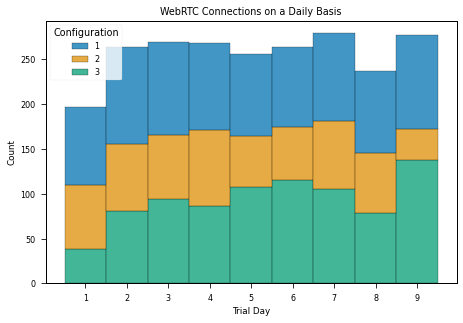

In [12]:
plot_hist(connections_pd[['Trial Day', 'Call', 'Configuration']], 'Trial Day', 'WebRTC Connections on a Daily Basis', 'Configuration', save=True, prefix='perf').show()

In [13]:
# performance data
performance_json_1 = Path('./data/performance.json')
performance_json_2 = Path('./data/performance_2.json')

In [14]:
performance_pd = pd.concat([pd.read_json(performance_json_1, lines=True), pd.read_json(performance_json_2, lines=True)])
performance_pd.event_timestamp = performance_pd.event_timestamp.apply(to_dt)
performance_pd = performance_pd[(performance_pd.event_timestamp>=config_1_date) & (performance_pd.event_timestamp<=config_3_date_end) & (performance_pd.app_display_version=='2.0')]
performance_pd = performance_pd[performance_pd.trace_info.apply(lambda x: isinstance(x, dict))]

In [15]:
performance_pd['trial'] = performance_pd.event_timestamp.apply(set_trial, args=(config_1_date, config_1_date_end, config_2_date, config_2_date_end, config_3_date, config_3_date_end))
performance_pd = performance_pd[performance_pd.trial!=0]
performance_pd['Trial Day'] = performance_pd.apply(set_day_of_trial, args=(config_1_date, config_2_date, config_3_date), axis=1)

In [16]:
print(performance_pd[performance_pd.event_name=='Trainer'].iloc[0].trace_info)
print(performance_pd.iloc[0].trace_info)

def trace_info_duration(trace_info):
    return pd.to_timedelta('{}us'.format(trace_info.get('duration_us'))).total_seconds() * 1e3

performance_pd['Duration (ms)'] = performance_pd.trace_info.apply(trace_info_duration)

{'duration_us': '4593248'}
{'duration_us': '224', 'metric_info': {'metric_value': '1'}}


In [17]:
def trace_info_metric(trace_info):
    if 'metric_info' in trace_info:
        return int(trace_info.get('metric_info').get('metric_value'))
    return -1  # if it is -1, then there is no parent_trace_name as it is just a plain trace with no metric

performance_pd['Metric Count'] = performance_pd.trace_info.apply(trace_info_metric)

In [18]:
performance_pd['Configuration'] = performance_pd.trial.apply(set_config_num)

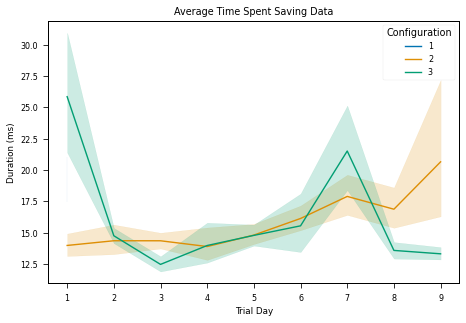

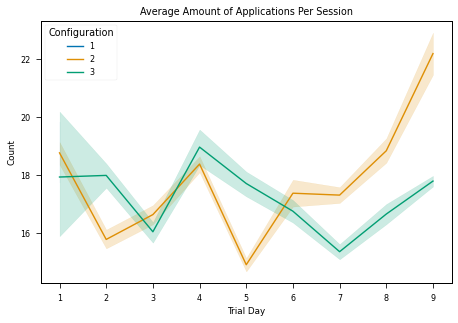

In [19]:
save_data_app_count_pd = performance_pd[performance_pd.event_name=='save_data_app_count']
save_data_app_count_pd.trial.value_counts()
plot_line2(save_data_app_count_pd, 'Trial Day', 'Duration (ms)', 'Trial Day', 'Duration (ms)', 'Average Time Spent Saving Data', 'Configuration', save=True, prefix='perf').show()
plot_line2(save_data_app_count_pd[['Trial Day', 'Configuration', 'Metric Count']], 'Trial Day', 'Metric Count', 'Trial Day', 'Count', 'Average Amount of Applications Per Session', hue='Configuration', save=True, prefix='perf').show()

<ipython-input-20-e8c8848d7399>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainModel_pd['Duration (s)'] = trainModel_pd['Duration (ms)'].apply(lambda x: x/1000)


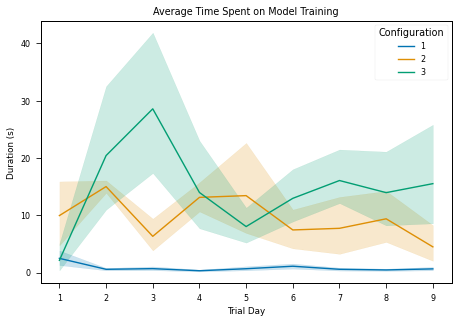

In [20]:
trainModel_pd = performance_pd[performance_pd.event_name=='trainModel']
trainModel_pd['Duration (s)'] = trainModel_pd['Duration (ms)'].apply(lambda x: x/1000)
plot_line2(trainModel_pd, 'Trial Day', 'Duration (s)', 'Trial Day', 'Duration (s)', 'Average Time Spent on Model Training', hue='Configuration', save=True, prefix='perf').show()

<ipython-input-21-53e8b9dd7c4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_model_pd['Duration (s)'] = training_model_pd['Duration (ms)'].apply(lambda x: x / 1000)
<ipython-input-21-53e8b9dd7c4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_model_pd['Task'] = training_model_pd.event_name.apply(lambda x: 'Model Training' if x=='trainModel' else ('Setup, Train, Export' if x=='Trainer' else 'Data Setup'))


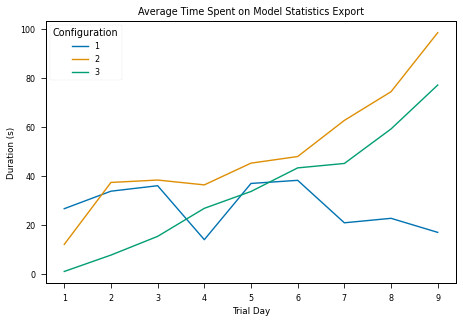

In [21]:
df = pd.DataFrame()
training_model_pd = performance_pd[(performance_pd.event_name=='trainModel') | (performance_pd.event_name=='setUpData') | (performance_pd.event_name=='Trainer')]
training_model_pd['Duration (s)'] = training_model_pd['Duration (ms)'].apply(lambda x: x / 1000)
training_model_pd['Task'] = training_model_pd.event_name.apply(lambda x: 'Model Training' if x=='trainModel' else ('Setup, Train, Export' if x=='Trainer' else 'Data Setup'))


for config in range(1, 4):
    export_avgs = list()
    export_df = pd.DataFrame(['Export']*9)
    config_df = pd.DataFrame([config]*9)
    trial_day_df = pd.DataFrame([1,2,3,4,5,6,7,8,9])
    config_data = training_model_pd[training_model_pd.Configuration==config]
    for day in range(1, 10):
        setup_avg = config_data[(config_data['Trial Day']==day) & (config_data.event_name=='setUpData')]['Duration (ms)'].mean()
        trainModel_avg = config_data[(config_data['Trial Day']==day) & (config_data.event_name=='trainModel')]['Duration (ms)'].mean()
        trainer_avg = config_data[(config_data['Trial Day']==day) & (config_data.event_name=='Trainer')]['Duration (ms)'].mean()
        export_avgs.append(abs(trainer_avg - (setup_avg + trainModel_avg)))
    df = pd.concat([df, pd.concat([pd.DataFrame(export_avgs), export_df, config_df, trial_day_df], axis=1, ignore_index=True)], ignore_index=True)

df = df.rename(columns={0: 'Duration (ms)', 1: 'event_name', 2: 'Configuration', 3: 'Trial Day'})
df['Duration (s)'] = df['Duration (ms)'].apply(lambda x: x/1000)
df['Task'] = df.event_name

plot_line2(df, 'Trial Day', 'Duration (s)', 'Trial Day', 'Duration (s)', 'Average Time Spent on Model Statistics Export', hue='Configuration', ci=95, save=True, prefix='perf').show()

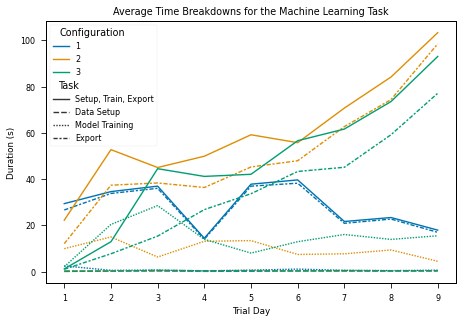

In [22]:
plot_line2(pd.concat([training_model_pd, df]), 'Trial Day', 'Duration (s)', 'Trial Day', 'Duration (s)', 'Average Time Breakdowns for the Machine Learning Task', hue='Configuration', style='Task', ci=None, save=True, prefix='pref').show()

<ipython-input-23-b0b50f0f9f04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setUpData_pd['Duration (s)'] = setUpData_pd['Duration (ms)'].apply(lambda x: x/1000)


<module 'matplotlib.pyplot' from '/home/anguel/AndroidStudioProjects/level5dissertation/data/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

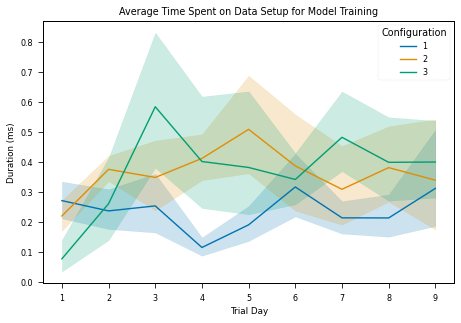

In [23]:
setUpData_pd = performance_pd[performance_pd.event_name=='setUpData']
setUpData_pd['Duration (s)'] = setUpData_pd['Duration (ms)'].apply(lambda x: x/1000)
plot_line2(setUpData_pd, 'Trial Day', 'Duration (s)', 'Trial Day', 'Duration (ms)', 'Average Time Spent on Data Setup for Model Training', hue='Configuration', save=True, prefix='perf')

<ipython-input-24-cdec44813e88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trainer_pd['Duration (s)'] = Trainer_pd['Duration (ms)'].apply(lambda x: x/1000)


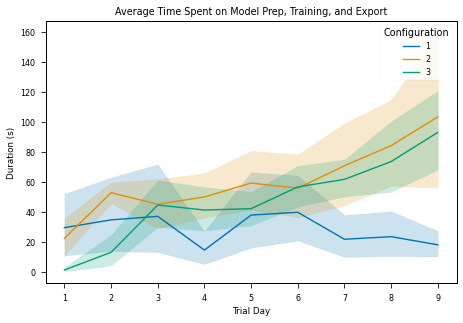

In [24]:
Trainer_pd = performance_pd[performance_pd.event_name=='Trainer']
Trainer_pd['Duration (s)'] = Trainer_pd['Duration (ms)'].apply(lambda x: x/1000)
plot_line2(Trainer_pd, 'Trial Day', 'Duration (s)', 'Trial Day', 'Duration (s)', 'Average Time Spent on Model Prep, Training, and Export', 'Configuration', save=True, prefix='perf').show()

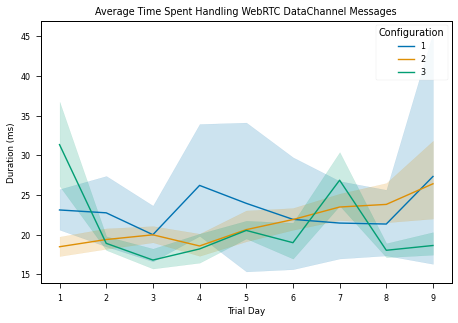

In [25]:
dcObserverOnMessage_pd = performance_pd[performance_pd.event_name=='dcObserverOnMessage']
plot_line2(dcObserverOnMessage_pd, 'Trial Day', 'Duration (ms)', 'Trial Day', 'Duration (ms)', 'Average Time Spent Handling WebRTC DataChannel Messages', 'Configuration', save=True, prefix='perf').show()

In [26]:
# sentry data
sentry_csv = Path('./data/sentry_issues_export.csv')
sentry_pd = pd.read_csv(sentry_csv)

count_sum = sentry_pd['count'].sum()
sentry_pd = sentry_pd.sort_values(by=['count'], ascending=False, ignore_index=True)
print(count_sum)
# top 10
for i in range(10):
    cur = sentry_pd.iloc[i]
    print(cur)
    print((cur['count'] / count_sum) * 100) 
    print('-----')

3385
count                                                     2189
title                                             EOFException
status                                              unresolved
lastSeen                           2021-03-30T08:33:43.940000Z
firstSeen                          2021-03-02T11:21:39.108000Z
culprit                     okio.RealBufferedSource in require
permalink    https://sentry.io/organizations/level5disserta...
Name: 0, dtype: object
64.66765140324962
-----
count                                                      790
title                  JSONException: No value for appCategory
status                                              unresolved
lastSeen                           2021-03-21T01:47:07.111000Z
firstSeen                          2021-03-03T15:03:13.266000Z
culprit      com.anguel.dissertation.persistence.converters...
permalink    https://sentry.io/organizations/level5disserta...
Name: 1, dtype: object
23.338257016248154
-----
count             

In [27]:
# survey data
survey_pd = pd.read_csv('./data/survey.csv')
print(survey_pd.columns)
print('-------')

print('avg age: ', survey_pd.Age.mean())
print('std dev age: ', survey_pd.Age.std())
print('min max age: ', survey_pd.Age.min(), survey_pd.Age.max())
print('-------')

survey_android_version = pd.Series([10, 8, 10, 9, 7, 11, 11, 10, 10, 10, 10, 10, 10, 11, 8, 11, 11, 11, 9, 10, 10, 10])
print(survey_android_version.size)
print(survey_android_version.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print('--------')

survey_sias = survey_pd['Was your SIAS score above 33? (This can be found in the Settings, which can be found by clicking on the 3 dots on the top right of the screen when the app is launched)']
print(survey_sias.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
survey_android_manufacturer = pd.Series(['1plus', '1plus', '1plus', '1plus', 'samsung', 'samsung', 'samsung', 'samsung', 'samsung', 'samsung', 'samsung',
                                         'xiaomi', 'xiaomi', 'xiaomi', 'xiaomi', 'xiaomi', 'pixel', 'pixel', 'pixel', 'moto', 'lg', 'huawei'])
print('--------')
print(survey_android_manufacturer.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Index(['Timestamp', 'Age',
       'Was your SIAS score above 33? (This can be found in the Settings, which can be found by clicking on the 3 dots on the top right of the screen when the app is launched)',
       'Phone make and model', 'Android version',
       'Did you experience any noticeable lag from the application during the trial?',
       'Did you experience any noticeable battery drain from the application during the trial?',
       'Do you think you consciously tried to alter your behaviour during the trial?',
       'At some point in the trial, did you turn off the data collection manually? If so, could you please describe what the situation was (e.g. thought it was too invasive, needed to save battery, etc)',
       'Were there instances in which the application was turned off by the phone and not by you?',
       'Did you feel comfortable knowing that the epidemic algorithm was anonymously sharing data between participants?',
       'Did you feel comfortable knowing that t

In [28]:
# survey data contd.
epi_sharing_comfort = pd.DataFrame([4]*9 + [5]*5 + [3]*4 + [2]*3 + [1]*2)
epi_sharing_comfort = epi_sharing_comfort.rename({0: 'Comfort Level (1=least, 5=very)'},axis=1)
print(epi_sharing_comfort.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print('-----')

future_epi_usage = pd.DataFrame(['Yes']*8 + ['No']*9 + ['Depends']*6)
print(future_epi_usage.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print('-----')

data_analysis_on_phone_comfort = pd.DataFrame([4]*11 + [5]*9 + [3]*2 + [2]*1)
data_analysis_on_phone_comfort = data_analysis_on_phone_comfort.rename({0: 'Comfort Level (1=least, 5=very)'},axis=1)
print(data_analysis_on_phone_comfort.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print('-----')

usage_stats_comfort = pd.DataFrame([3]*7 + [2]*6 + [5]*5 + [4]*4 + [1])
usage_stats_comfort = usage_stats_comfort.rename({0: 'Comfort Level (1=least, 5=very)'},axis=1)
print(usage_stats_comfort.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print('-----')

centralised_comfort = pd.DataFrame([3]*10 + [2]*5 + [4]*4 + [5]*2 + [1])
centralised_comfort = centralised_comfort.rename({0: 'Comfort Level (1=least, 5=very)'},axis=1)
print(centralised_comfort.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print('-----')

fed_comfort = pd.DataFrame([4]*10 + [3]*9 + [5]*2 + [2]*1)
fed_comfort = fed_comfort.rename({0: 'Comfort Level (1=least, 5=very)'},axis=1)
print(fed_comfort.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Comfort Level (1=least, 5=very)
4                                  39.13%
5                                  21.74%
3                                  17.39%
2                                  13.04%
1                                    8.7%
dtype: object
-----
No         39.13%
Yes        34.78%
Depends    26.09%
dtype: object
-----
Comfort Level (1=least, 5=very)
4                                  47.83%
5                                  39.13%
3                                    8.7%
2                                   4.35%
dtype: object
-----
Comfort Level (1=least, 5=very)
3                                  30.43%
2                                  26.09%
5                                  21.74%
4                                  17.39%
1                                   4.35%
dtype: object
-----
Comfort Level (1=least, 5=very)
3                                  45.45%
2                                  22.73%
4                                  18.18%
5                       

In [29]:
# convert timestamp
all_models_pd['timestamp_utc'] = all_models_pd.timestamp.apply(to_dt)
# remove those that were there before trial began
all_models_pd = all_models_pd[all_models_pd.timestamp_utc>=config_1_date]
all_models_pd = all_models_pd.drop(columns=['timestamp'])

all_models_pd.confusionMatrix = all_models_pd.confusionMatrix.apply(confusion_na)
all_models_pd = all_models_pd[all_models_pd.confusionMatrix!='']

In [30]:
cols = all_models_pd.columns.tolist()
cols[-1],cols[1] = cols[1],cols[-1]
all_models_pd = all_models_pd[cols]

In [31]:
def count_overall_anxious(row):
    return row.trainingInfo_anxiousCountTest + row.trainingInfo_anxiousCountTrain

def count_overall_non_anxious(row):
    return row.trainingInfo_testSize + row.trainingInfo_trainSize

def count_overall_data_size(row):
    return row.trainingInfo_anxiousCountTest + row.trainingInfo_anxiousCountTrain + row.trainingInfo_testSize + row.trainingInfo_trainSize

all_models_pd['overall_anxious'] = all_models_pd.apply(count_overall_anxious, axis=1)
all_models_pd['overall_data'] = all_models_pd.apply(count_overall_data_size, axis=1)
all_models_pd['overall_non_anxious'] = all_models_pd.apply(count_overall_non_anxious, axis=1)

all_models_pd['overall_anxious'] = all_models_pd['overall_anxious'].astype(int)
all_models_pd['overall_data'] = all_models_pd['overall_data'].astype(int)
all_models_pd['overall_non_anxious'] = all_models_pd['overall_non_anxious'].astype(int)

In [32]:
all_models_pd = all_models_pd[(all_models_pd.validationMetrics_f1score<=1.0) & (all_models_pd.validationMetrics_f1score>=0.0)]

In [33]:
all_models_pd['trial'] = all_models_pd.timestamp_utc.apply(set_trial, args=(config_1_date, config_1_date_end, config_2_date, config_2_date_end, config_3_date, config_3_date_end))
all_models_pd['trialDay'] = all_models_pd.apply(set_day_of_trial, args=(config_1_date, config_2_date, config_3_date), axis=1)

all_models_pd = all_models_pd[(all_models_pd.trial!=0) & (all_models_pd.trialDay!=-1)]

In [34]:
config_1_data = all_models_pd[all_models_pd.trial==3]
config_2_data = all_models_pd[all_models_pd.trial==2]
config_3_data = all_models_pd[all_models_pd.trial==1]

In [35]:
config_1_data_avgs = dict()
for x in range(1,10):
    c = config_1_data[config_1_data.modelType=='COMBINED']
    c = c[c.trialDay==x]
    config_1_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_1_data_avgs_pd = pd.DataFrame.from_dict(config_1_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_1_data_avgs_pd.T)
display(config_1_data_avgs_pd.accuracy.pct_change())
q = pd.DataFrame(config_1_data_avgs_pd.accuracy.pct_change())


config_1_data_avgs = dict()
for x in range(1, 10):
    c = config_1_data[config_1_data.modelType=='DAILY']
    c = c[c.trialDay==x]
    config_1_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_1_data_avgs_pd = pd.DataFrame.from_dict(config_1_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_1_data_avgs_pd.T)
display(config_1_data_avgs_pd.accuracy.pct_change())

,1,2,3,4,5,6,7,8,9
accuracy,61.149020,29.386732,13.366621,6.683310,3.021605,43.207369,10.129596,5.064798,2.532399
accuracy std,48.225139,24.154488,12.399224,6.199612,3.009248,48.532255,18.176347,9.088173,4.544087
overall data,13715.545455,15546.000000,18517.428571,19350.571429,17960.250000,13047.461538,8682.250000,9236.625000,10070.875000
anxious data,460.636364,0.000000,0.000000,0.000000,0.000000,628.769231,0.000000,0.000000,0.000000
% anxious,3.358498,0.000000,0.000000,0.000000,0.000000,4.819092,0.000000,0.000000,0.000000
f1,0.535987,0.286292,0.128311,0.064156,0.029045,0.431713,0.101003,0.050502,0.025251
f1 std,0.443902,0.237424,0.119947,0.059974,0.029058,0.485649,0.181925,0.090963,0.045481


1          NaN
2    -0.519424
3    -0.545148
4    -0.500000
5    -0.547888
6    13.299478
7    -0.765559
8    -0.500000
9    -0.500000
Name: accuracy, dtype: float64

,1,2,3,4,5,6,7,8,9
accuracy,95.051465,98.911890,100.000000,100.000000,100.000,100.000000,100.000,100.000,100.00
accuracy std,2.779650,3.077641,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.00
overall data,2466.545455,1477.875000,1747.714286,1666.285714,1747.250,2599.692308,1054.250,1108.750,1668.50
anxious data,722.272727,716.250000,873.857143,833.142857,873.625,1299.846154,527.125,554.375,834.25
% anxious,29.282766,48.464857,50.000000,50.000000,50.000,50.000000,50.000,50.000,50.00
f1,0.871203,0.988388,1.000000,1.000000,1.000,1.000000,1.000,1.000,1.00
f1 std,0.148763,0.032844,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.00


1         NaN
2    0.040614
3    0.011001
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: accuracy, dtype: float64

In [36]:
config_2_data_avgs = dict()
for x in range(1, 10):
    c = config_2_data[config_2_data.modelType=='COMBINED']
    c = c[c.trialDay==x]
    config_2_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_2_data_avgs_pd = pd.DataFrame.from_dict(config_2_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_2_data_avgs_pd.T)
display(config_2_data_avgs_pd.accuracy.pct_change())
q2 = config_2_data_avgs_pd.accuracy.pct_change()


config_2_data_avgs = dict()
for x in range(1, 10):
    c = config_2_data[config_2_data.modelType=='DAILY']
    c = c[c.trialDay==x]
    config_2_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_2_data_avgs_pd = pd.DataFrame.from_dict(config_2_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_2_data_avgs_pd.T)
display(config_2_data_avgs_pd.accuracy.pct_change())

,1,2,3,4,5,6,7,8,9
accuracy,53.476596,44.948247,27.795335,21.920388,11.106255,4.785444,2.129987,1.027150,0.393006
accuracy std,46.725669,37.357333,24.820841,28.828747,14.578143,5.743003,2.577305,1.223315,0.466196
overall data,23932.562500,18835.162162,22750.375000,25119.312500,24860.142857,29839.000000,32679.733333,35718.571429,40431.600000
anxious data,1081.937500,401.662162,38.375000,386.375000,0.000000,0.000000,0.000000,0.000000,0.000000
% anxious,4.520776,2.132512,0.168679,1.538159,0.000000,0.000000,0.000000,0.000000,0.000000
f1,0.491568,0.394495,0.215268,0.188611,0.094932,0.037167,0.016329,0.008059,0.002127
f1 std,0.446510,0.348822,0.219941,0.294063,0.150774,0.060059,0.026792,0.013077,0.001808


1         NaN
2   -0.159478
3   -0.381615
4   -0.211364
5   -0.493337
6   -0.569122
7   -0.554903
8   -0.517767
9   -0.617382
Name: accuracy, dtype: float64

,1,2,3,4,5,6,7,8,9
accuracy,92.955259,94.466317,95.405174,94.023916,94.908835,95.117299,94.397757,93.838087,92.894721
accuracy std,2.352935,1.266085,3.002001,1.870396,2.199326,2.166757,3.352347,2.242100,3.264153
overall data,7674.312500,7197.830000,4338.722222,7050.921053,6645.444444,5427.200000,4446.277778,6306.588235,2849.500000
anxious data,2246.312500,1268.990000,750.944444,1461.368421,1799.444444,1509.133333,1364.833333,1909.176471,815.833333
% anxious,29.270537,17.630175,17.307963,20.725922,27.077865,27.806849,30.696088,30.272731,28.630754
f1,0.868517,0.862128,0.773334,0.838431,0.883434,0.878968,0.929417,0.893612,0.833991
f1 std,0.116770,0.038930,0.224476,0.076040,0.115658,0.094139,0.052726,0.092694,0.151172


1         NaN
2    0.016256
3    0.009939
4   -0.014478
5    0.009412
6    0.002196
7   -0.007565
8   -0.005929
9   -0.010053
Name: accuracy, dtype: float64

In [37]:
config_3_data_avgs = dict()
for x in range(1, 10):
    c = config_3_data[config_3_data.modelType=='COMBINED']
    c = c[c.trialDay==x]
    config_3_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_3_data_avgs_pd = pd.DataFrame.from_dict(config_3_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_3_data_avgs_pd.T)
display(config_3_data_avgs_pd.accuracy.pct_change())

config_3_data_avgs = dict()
for x in range(1, 10):
    c = config_3_data[config_3_data.modelType=='DAILY']
    c = c[c.trialDay==x]
    config_3_data_avgs[x] = [
        c.oobMetrics_accuracy.mean() * 100.000,
        c.oobMetrics_accuracy.std() * 100.00,
        c.overall_data.mean(),
        c.overall_anxious.mean(),
        c.overall_anxious.mean() / c.overall_data.mean() * 100.00,
        c.validationMetrics_f1score.mean(),
        c.validationMetrics_f1score.std()
    ]

config_3_data_avgs_pd = pd.DataFrame.from_dict(config_3_data_avgs, orient='index', columns=['accuracy', 'accuracy std', 'overall data', 'anxious data', '% anxious', 'f1', 'f1 std'])
display(config_3_data_avgs_pd.T)
display(config_3_data_avgs_pd.accuracy.pct_change())

,1,2,3,4,5,6,7,8,9
accuracy,74.822751,80.564532,68.197932,38.259108,21.886099,14.539214,29.112414,8.015949,3.538020
accuracy std,28.964119,32.769758,25.460166,22.486141,19.755505,21.007772,37.718717,14.771307,6.593400
overall data,1749.000000,11410.909091,17737.764706,20221.526316,24015.200000,29119.666667,22054.640000,37757.777778,45634.380952
anxious data,276.333333,2161.818182,1190.411765,157.894737,51.650000,17.000000,180.920000,0.000000,0.000000
% anxious,15.799504,18.945188,6.711171,0.780825,0.215072,0.058380,0.820326,0.000000,0.000000
f1,0.717431,0.738982,0.600926,0.324553,0.157042,0.087963,0.244269,0.054484,0.020265
f1 std,0.253410,0.304804,0.258651,0.236036,0.196562,0.136119,0.341745,0.110716,0.040885


1         NaN
2    0.076738
3   -0.153499
4   -0.438999
5   -0.427951
6   -0.335687
7    1.002337
8   -0.724655
9   -0.558627
Name: accuracy, dtype: float64

,1,2,3,4,5,6,7,8,9
accuracy,91.054202,95.167778,94.397209,93.528358,94.946850,95.527968,95.167415,94.015617,94.043216
accuracy std,2.175421,1.216691,2.467163,3.959546,3.431992,1.949256,1.653542,2.201805,2.194970
overall data,1215.166667,11153.545455,13738.117647,6889.210526,5939.789474,7339.619048,6837.860000,7937.611111,8150.238095
anxious data,377.000000,2305.181818,2772.000000,1631.105263,942.210526,1059.380952,1256.640000,1470.888889,1886.000000
% anxious,31.024551,20.667705,20.177437,23.676229,15.862692,14.433732,18.377680,18.530624,23.140428
f1,0.916326,0.885747,0.856611,0.863984,0.703996,0.807247,0.849538,0.839539,0.847710
f1 std,0.048801,0.098031,0.077118,0.119389,0.243002,0.126234,0.084983,0.069071,0.103220


1         NaN
2    0.045177
3   -0.008097
4   -0.009204
5    0.015166
6    0.006120
7   -0.003774
8   -0.012103
9    0.000294
Name: accuracy, dtype: float64